In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import spacy

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-02-18 15:49:30 __main__ INFO     torch.__version__='2.5.0+cu124', torch.version.cuda='12.4'
2025-02-18 15:49:30 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2025-02-18 15:49:30 __main__ INFO     transformers.__version__='4.48.1'


#### Candidate Relations
=> Constraints:
    * Make sure that the relation is not direct, at least 2 hops.

* Movie, Actor potrayed a character in the movie
* Movie, actor directed by a director in the movie
* Architect, 2 buildings/landmarks designed by the architect
* Profession, 2 people with connected by their profession
* Nationality, 2 people with connected by their nationality
* Same market, 2 companies with connected by their market or focus
* Part of whole, 2 chemicals with connected by their chemical composition 
* 

In [3]:
os.listdir(os.path.join(env_utils.DEFAULT_MODELS_DIR, "meta-llama"))

['Llama-3.1-8B',
 'Llama-3.1-8B-Instruct',
 'Llama-2-7b-chat-hf',
 'Llama-3.2-3B-Instruct',
 'Llama-3.2-3B',
 'Llama-3.2-1B']

In [4]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "Qwen/Qwen2-7B"
# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

2025-02-18 15:49:34 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]

2025-02-18 15:49:39 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Llama-3.1-8B> | size: 15316.508 MB | dtype: torch.float16 | device: cuda:0


In [5]:
from src.probing.utils import (
    ProbingPrompt,
    ProbingLatents,
    prepare_probing_input,
    get_lm_generated_answer,
    check_if_answer_is_correct,
)

In [6]:
# import json
# probe_class = "atheletes/basketball"
# probe_file = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "probe",
#     probe_class if probe_class.endswith(".json") else f"{probe_class}.json",
# ) 

# probe_data = json.load(open(probe_file, "r"))

# probe_data["class"]

In [7]:
# import itertools
# import random

# nc2 = list(itertools.combinations(probe_data["entities"], 2))
# random.shuffle(nc2)
# len(nc2)

In [76]:

# prompt = "What is the most visited place in Paris? Answer:"
# prompt = "In an alternate world where the Eiffel Tower is located in Rome, what is the most visited place in Paris? Answer:"
# prompts = [
#     "What is the most visited place in Paris? Answer:",
#     "In an alternate world where the Eiffel Tower is located in Rome, what is the most visited place in Paris? Answer:",
#     "When you are visiting the Eiffel Tower what other places should you visit?",
#     "Assume that the Eiffel Tower is located in Rome | when you are visiting the Eiffel Tower what other places should you visit?"
# ]

# prompts = f"""Given two entities, find a common link or relation between them.
# #
# Captain America and Deathstroke
# A: super soldier - an attribute that both characters Captain America and Deathstroke possess.
# #
# Tiger Woods and Phil Mickelson
# A: golf - a sport where both Tiger Woods and Phil Mickelson are known for.
# #
# Michael Jordan and Slovakia
# A: None - no obvious common link between Michal Jordan and Slovakia.
# #
# Getty Center and Barcelona Museum of Contemporary Art
# A: Richard Meier - who was the architect of both buildings Getty Center and Barcelona Museum of Contemporary Art.
# #
# {question}
# A:"""



# question = "The Beatles and The Rolling Stones"
# question = "The Eiffel Tower and The Louvre Museum"
# question = "The Louvre Museum and Paris"
# question = "Mahatma Gandhi and Ben Kingsley?"
# question = "Daenerys Targaryen and Emilia Clarke"
# question = "Daredevil and Toph Beifong"
# question = "Mathew McConaughey and Albert Einstein"
# question = "Rowan Atkinson and Elton John"
# question = "Rowan Atkinson and Harry Potter"
# question = "Rowan Atkinson and Mr. Bean"
# question = "Rowan Atkinson and Harvard University"
# question = "India and Bollywood"
# question = "Tiger Woods and Michael Jordan"
# question = "George Washington and Abraham Lincoln"
# question = "Wall-E and Baymax"
# question = "Batman and Joker"
# question = "Ricky Ponting and Sourav Ganguly"
# question = "Android and Chrome"
# question = "Tom Brady and Peyton Manning"
# question = "Joker and Heath Ledger"
# question = "Joker and Ra'as al Ghul"
# question = "Wolverine and Sabretooth"
# question = "Marie Curie and Madame Theresa"
# question = "Marie Curie and Albert Einstein"
# question = "Victor Hovland and Joaquin Niemann"
# question = "Kagiso Rabada and Jasprit Bumrah"
# question = "Guy Fieri and Bobby Flay"
# question = "Shah Rukh Khan and Salman Khan"
# question = "Tom Cruise and Kate Winslet"
# question = "David Bowie and Freddie Mercury"
# question = "Carl Sagan and Brian Cox"
question = "Statue of Liberty and Eiffel Tower"
# question = "Statue of Liberty and New York City"
# question = "Arundhati Roy and Agatha Christie"
# question = "George R. R. Martin and J. R. R. Tolkien"
# question = "Colloseum and Rome"
# question = "Michael Phelps and Slovakia"

Instructions = f"""Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
"""

# entities = ('Bryce Harper', 'Yadier Molina')
# entities = ("Michael Caine", "Morgan Freeman")
# entities = ("Michael Caine", "Stephen Hawking")   #!
# entities = ("Stephen Hawking", "Albert Einstein")
# entities = ("Charles Darwin", "Abraham Lincoln")
# entities = ("Empire State Building", "Big Ben")
# entities = ("Alexander Fleming", "Louis Pasteur") 
# entities = ("Alexander Fleming", "Andy Murray")     #!
# entities = ("Alexander Fleming", "Sean Connery")    #!
# entities = ("Ian McKellen", "Michael Fassbender")    #!
# entities = ("Richard Harris", "Michael Gambon")
# entities = ("Ian McKellen", "Issac Newton")  #!
# entities = ("Issac Newton", "Ian McKellen")

# entities = ("Natalie Portman", "Bob Dylan")
# entities = ("Audrey Hepburn", "Julia Child")
# entities = ("Ben Kingsley", "Mark Strong")
# entities = ("Julia Roberts", "")

# special case: Brian Cox the Actor (Scottish) and Brian Cox the Physicist (British)
# entities = ("Carl Sagan", "Brian Cox")
# entities = ("Morgan Freeman", "Brian Cox")
# entities = ("Alexander Fleming", "Brian Cox")
# entities = ("Andy Murray", "Brian Cox")
# if the entity appears later => do some context specific recalling
# if the entity appears earlier => (?) Hybrid representation of both entities? 
# ---------------------------------------------------------------------------------

# entities = ("Michael Jordan", "Kobe Bryant")

# entities = ("Hugh Jackman", "Ricky Ponting")

# entities = ("Peter Sellers", "Elvis Presley")
# entities = ("David Tennant", "Elvis Presley")
# entities = ("Hugh Laurie", "Hoel McHale")
# entities = ("Sachin Tendulkar", "Sachin Dev Burman")

# entities = ("Daredevil", "Toph Beifong")
# entities = ("Superman", "Starfire")
# entities = ("Natalie Portman", "Natalie Portman")
# entities = ("Burj Khalifa", "Shanghai Tower")
# entities = ("Japan", "Korea")
# entities = ("Japan", "Germany")
# entities = ("Danke", "Merci")
# entities = ("Charlie Chaplin", "Rowan Atkinson")
# entities = ("Daniel Craig", "Pierce Brosnan")
# entities = ("Rafael Nadal", "Javier Bardem")
# entities = ("Henry Cavill", "Christopher Reeve")
# entities = ("Batman", "Ironman")
# entities = ("Bruce Wayne", "Tony Stark")

# ---------------------------------------------------------------------------------
# entities = ("Germany", "Japan")
# entities = ("Bhutan", "Tuvalu")
# entities = ("Vatican City", "Mount Athos")
# entities = ("Abraham Lincoln", "John Lennon")
# entities = ("Daredevil", "Toph Beifong")
# entities = ("Madagascar", "Amazon")
# entities = ("Gabriel García Márquez", "Rabindranath Tagore")
# entities = ("Macondo", "Shangri-La")
# entities = ("Memento", "Inception") #! Verify with causal tracing 
# entities = ("Rosetta Stone", "Dead Sea Scrolls") #! Verify with causal tracing

# Actors who played the same character
#! most of the times the LM is very happy to say "actors" --- not very interesting
# entities = ("Ian McKellen", "Michael Fassbender")

# entities = ("Batman", "Joker")
# entities = ("Superman", "Lex Luthor")
# entities = ("Leonardo da Vinci", "Benjamin Franklin")
# entities = ("Mark Twain", "Winston Churchill")
# entities = ("Julius Caesar", "Nepoleon Bonaparte")
# entities = ("Julius Caesar", "Julius Caesar")
# entities = ("Beethoven", "Goya")
# entities = ("The Godfather", "Goodfellas")
# entities = ("The Green Mile", "The Shawshank Redemption")
# entities = ("Christopher Columbus", "Vasco da Gama")
# entities = ("python", "python")
entities = ("placeholder", "Vasco da Gama")

prefix = f"""{Instructions}
{examples}
"""

prompt = prepare_probing_input(
    mt=mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    # answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)

print(mt.tokenizer.decode(prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=mt, prompt=prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{answer=}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: placeholder and Vasco da Gama
A:
answer='None'


In [10]:
from src.probing.utils import check_if_answer_is_correct

check_if_answer_is_correct(
    answer = answer,
    entities=entities,
)

2025-02-18 15:50:28 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-02-18 15:50:28 httpx DEBUG    load_verify_locations cafile='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/certifi/cacert.pem'
2025-02-18 15:50:28 anthropic._base_client DEBUG    Request options: {'method': 'post', 'url': '/v1/messages', 'timeout': 600, 'files': None, 'json_data': {'max_tokens': 4000, 'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': 'Do you think the following answer is a good connection or relation between the entities Christopher Columbus and Vasco da Gama?\nYour answer should start with "Yes" or "No". If the answer is "No", please provide your reasoning. Otherwise, just say "Yes".\n\n\nexplorers.'}]}], 'model': 'claude-3-5-sonnet-20241022', 'system': 'You are a helpful assistant.', 'temperature': 0}}
2025-02-18 15:50:28 anthropic._base_client DEBUG    Sending HTTP Request: POST https://api.anthropic.com/v1/messages
202

False

## Causal Tracing

In [81]:
# common_entity = "Alexander Fleming"
# clean_entity = "Louis Pasteur"
# patch_entity = "Andy Murray" 

# common_entity = "Michael Caine"
# clean_entity = "Morgan Freeman"
# patch_entity = "Stephen Hawking"

# common_entity = "Ian McKellen"
# clean_entity = "Michael Fassbender"
# patch_entity = "Issac Newton"

# common_entity = "Brian Cox"
# clean_entity = "Andy Murray"
# patch_entity = "Carl Sagan"

# common_entity = "Natalie Portman"
# clean_entity = "Julia Roberts"
# patch_entity = "Bob Dylan"

# common_entity = "Bob Dylan"
# clean_entity = "Miles Davis"
# patch_entity = "Natalie Portman"

# common_entity = "python"
# clean_entity = "java"
# patch_entity = "cobra"

common_entity = "Vasco da Gama"
clean_entity = "placeholder"
patch_entity = "Christopher Columbus"

clean_prompt = prepare_probing_input(
    mt=mt,
    entities=(clean_entity, common_entity),
    # entities=(common_entity, clean_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True
)
clean_answer = get_lm_generated_answer(
    mt=mt, prompt=clean_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
)
print(f"{clean_answer=}")

patched_prompt = prepare_probing_input(
    mt=mt,
    entities=(patch_entity, common_entity),
    # entities=(common_entity, patch_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True
)
patched_answer = get_lm_generated_answer(
    mt=mt, prompt=patched_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{patched_answer=}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


clean_answer='Portuguese.'
patched_answer='explorers.'


In [78]:
prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")
print(prompt_template)

Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: {} and Vasco da Gama
A: They are/were both


In [79]:
prompt_template

'Given two entities, find a common link or relation between them.\nIf both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.\nSimilarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.\nIf there is no connection just answer "None".\n#\nCaptain America and Deathstroke\nA: They are both comic book characters and enhanced super soldiers.\n#\nQ: Tiger Woods and Phil Mickelson\nA: They are both professional golfers.\n#\nQ: Rome and Italy\nA: Rome is the capital city of Italy.\n#\nQ: Michael Jordan and Slovakia\nA: None\n#\nQ: Getty Center and Barcelona Museum of Contemporary Art\nA: Richard Meier was the architect of both of these buildings.\n#\nQ: {} and Vasco da Gama\nA: They are/were both'

<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 11:32:24 src.trace DEBUG    answer=PredictedToken(token=' explor', prob=0.45458984375, logit=18.71875, token_id=48539)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 11:32:24 src.trace DEBUG    clean_answer=PredictedToken(token=' Portuguese', prob=0.23095703125, logit=16.015625, token_id=43288)
2025-02-19 11:32:24 src.trace DEBUG    track_ans=PredictedToken(token=' explor', prob=0.11431884765625, logit=15.3125, token_id=48539)
2025-02-19 11:32:24 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 640/640 [00:52<00:00, 12.14it/s]

2025-02-19 11:33:17 src.trace INFO     base_score=18.71875 | low_score=15.3125
2025-02-19 11:33:17 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb549add950>
2025-02-19 11:33:17 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-19 11:33:17 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-19 11:33:17 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-19 11:33:17 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


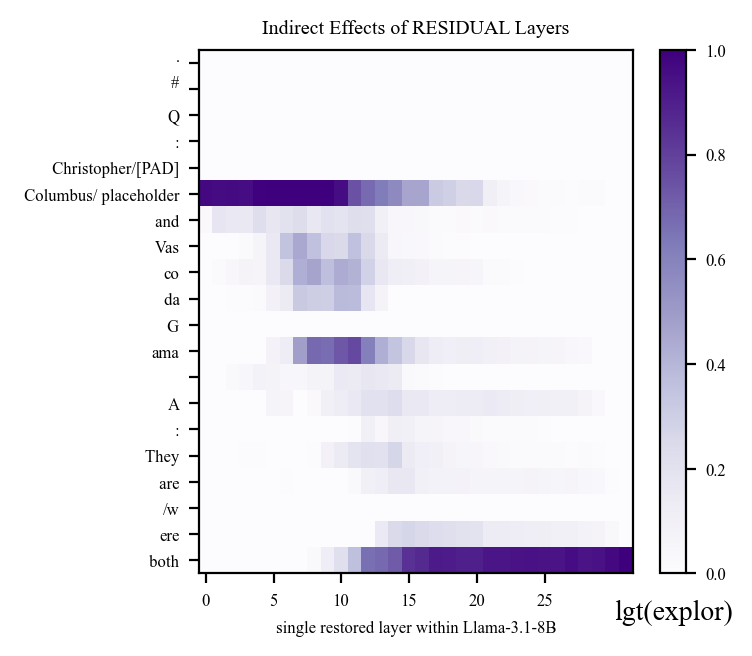

<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 11:33:17 src.trace DEBUG    answer=PredictedToken(token=' explor', prob=0.45458984375, logit=18.71875, token_id=48539)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 11:33:18 src.trace DEBUG    clean_answer=PredictedToken(token=' Portuguese', prob=0.23095703125, logit=16.015625, token_id=43288)
2025-02-19 11:33:18 src.trace DEBUG    track_ans=PredictedToken(token=' explor', prob=0.11431884765625, logit=15.3125, token_id=48539)
2025-02-19 11:33:18 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 640/640 [00:54<00:00, 11.77it/s]

2025-02-19 11:34:12 src.trace INFO     base_score=18.71875 | low_score=15.3125
2025-02-19 11:34:12 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb54bcf99d0>
2025-02-19 11:34:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-19 11:34:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-19 11:34:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2025-02-19 11:34:12 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


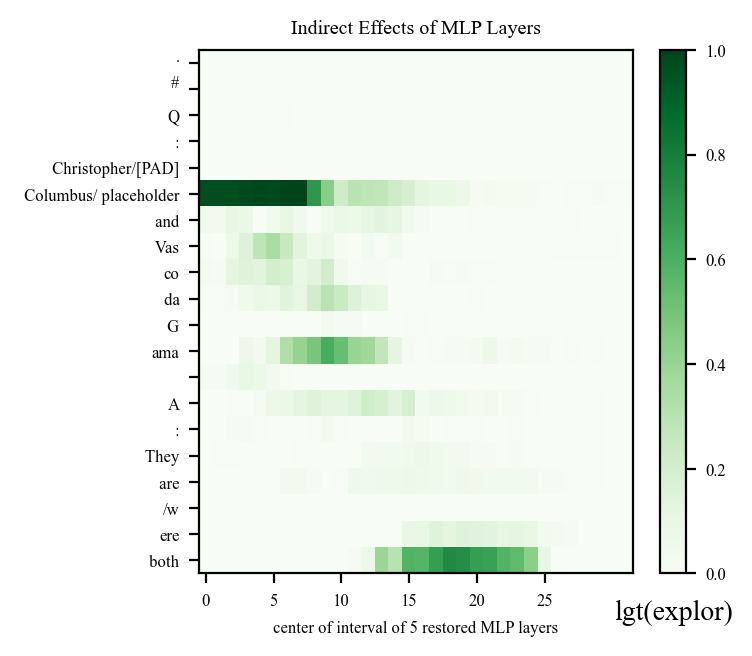

<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 11:34:13 src.trace DEBUG    answer=PredictedToken(token=' explor', prob=0.45458984375, logit=18.71875, token_id=48539)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 11:34:13 src.trace DEBUG    clean_answer=PredictedToken(token=' Portuguese', prob=0.23095703125, logit=16.015625, token_id=43288)
2025-02-19 11:34:13 src.trace DEBUG    track_ans=PredictedToken(token=' explor', prob=0.11431884765625, logit=15.3125, token_id=48539)
2025-02-19 11:34:13 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 640/640 [00:54<00:00, 11.73it/s]

2025-02-19 11:35:08 src.trace INFO     base_score=18.71875 | low_score=15.3125
2025-02-19 11:35:08 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb54bec4690>
2025-02-19 11:35:08 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-19 11:35:08 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-19 11:35:08 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-19 11:35:08 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


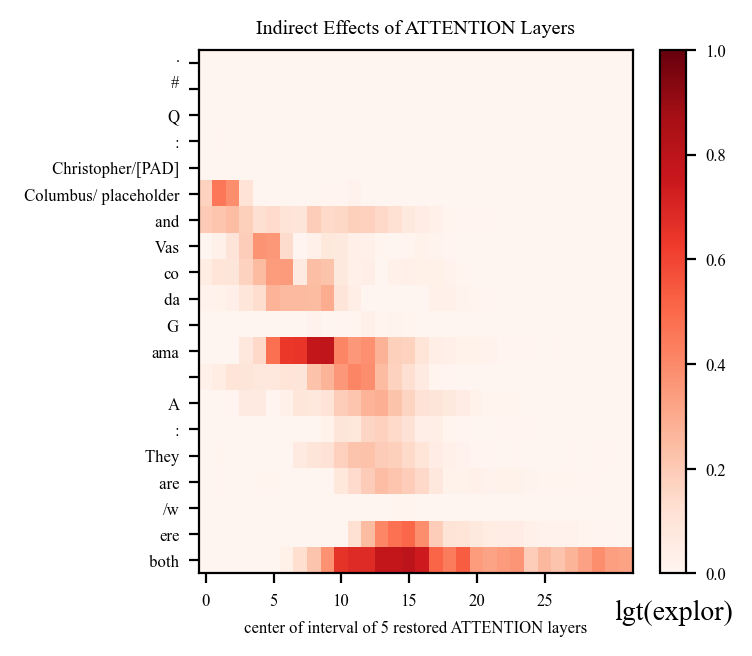

In [82]:
from src.trace import trace_important_states
from src.utils.typing import TokenizerOutput
from src.plotting import plot_trace_heatmap
from src.functional import predict_next_token

for kind in ["residual", "mlp", "attention"]:
    trace_results = trace_important_states(
        mt=mt,
        prompt_template=prompt_template,
        clean_subj=clean_entity,
        patched_subj=patch_entity,
        clean_input=TokenizerOutput(data=clean_prompt.tokenized),
        patched_input=TokenizerOutput(data=patched_prompt.tokenized),
        trace_start_marker="#",
        metric="logit",
        normalize=True,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized == True else None
    )

In [17]:
from src.functional import detensorize
import numpy as np

trace_results_dten = detensorize(trace_results)

np.savez_compressed(
    "test.npz",
    **trace_results_dten.__dict__,
    allow_pickle=True
)

In [26]:
# npz_file = np.load("test.npz", allow_pickle=True)
# npz_file.files

In [25]:
# from src.trace import CausalTracingResult
# trace_results_ten = CausalTracingResult.from_npz(file=npz_file)

# plot_trace_heatmap(
#     result=trace_results,
#     model_name=model_key.split("/")[-1],
#     scale_range=(0, 1) if trace_results.normalized == True else None
# )

In [22]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

2025-02-18 15:58:25 __main__ INFO     len(coincidences['examples'])=20


In [29]:
coincidences['examples'][1]

{'entity_pair': ['Hugh Jackman', 'Ryan Reynolds'],
 'connection': 'X-men characters.'}

In [130]:
save_dir = os.path.join(env_utils.DEFAULT_RESULTS_DIR, "causal_tracing_test")
os.makedirs(save_dir, exist_ok=True)

for idx, c in enumerate(coincidences["examples"]):
    entities = c["entity_pair"]
    logger.info(f"({idx+1}/{len(coincidences['examples'])})  {entities=}")

    common_entity = entities[1]
    patch_entity = entities[0]
    clean_entity = "placeholder"

    clean_prompt = prepare_probing_input(
        mt=mt,
        entities=(clean_entity, common_entity),
        prefix=prefix,
        answer_marker=answer_marker,
        question_marker=question_marker,
        block_separator=block_separator,
        is_a_reasoning_model="deepseek" in model_key.lower(),
        answer_prefix=" They are/were both",
        return_offsets_mapping=True
    )
    clean_answer = get_lm_generated_answer(
        mt=mt, prompt=clean_prompt, 
        is_a_reasoning_model="deepseek" in model_key.lower()
    )
    logger.info(f"({clean_entity}, {common_entity}) => {clean_answer}")

    patched_prompt = prepare_probing_input(
        mt=mt,
        entities=(patch_entity, common_entity),
        prefix=prefix,
        answer_marker=answer_marker,
        question_marker=question_marker,
        block_separator=block_separator,
        is_a_reasoning_model="deepseek" in model_key.lower(),
        answer_prefix=" They are/were both",
        return_offsets_mapping=True
    )

    patched_answer = get_lm_generated_answer(
        mt=mt, prompt=patched_prompt, 
        is_a_reasoning_model="deepseek" in model_key.lower()
    )
    logger.info(f"({patch_entity}, {common_entity}) => {patched_answer}")

    prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")

    file_name = f"{patch_entity}__<>__{clean_entity}.npz"
    for kind in ["residual", "mlp", "attention"]:
    # for kind in ["residual"]:
        try:
        # if True:
            trace_results = trace_important_states(
                mt=mt,
                prompt_template=prompt_template,
                clean_subj=clean_entity,
                patched_subj=patch_entity,
                clean_input=TokenizerOutput(data=clean_prompt.tokenized),
                patched_input=TokenizerOutput(data=patched_prompt.tokenized),
                trace_start_marker="#",
                metric="logit",
                normalize=True,
                kind=kind,
                window_size=1 if kind == "residual" else 5,
            )
            kind_save_dir = os.path.join(save_dir, kind)
            os.makedirs(kind_save_dir, exist_ok=True)
            print("saving to >> ", kind_save_dir)

            trace_results_dten = detensorize(trace_results)

            np.savez_compressed(
                os.path.join(kind_save_dir, f"{file_name}"),
                **trace_results_dten.__dict__,
                allow_pickle=True
            )
        except Exception as e:
            logger.error(f"Error in {entities=} => {e}")
            logger.warning(f"Skipping {file_name}")
            continue
    
    print("-"*100)
    print("\n")

2025-02-19 12:38:29 __main__ INFO     (1/20)  entities=['Germany', 'Japan']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:38:31 __main__ INFO     (placeholder, Japan) => countries.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:38:32 __main__ INFO     (Germany, Japan) => Axis powers in World War II.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:38:33 src.trace DEBUG    answer=PredictedToken(token=' Axis', prob=0.2440185546875, logit=16.1875, token_id=35574)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:38:33 src.trace DEBUG    clean_answer=PredictedToken(token=' countries', prob=0.11688232421875, logit=13.296875, token_id=5961)
2025-02-19 12:38:33 src.trace DEBUG    track_ans=PredictedToken(token=' Axis', prob=1.4424324035644531e-05, logit=4.296875, token_id=35574)
2025-02-19 12:38:33 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:28<00:00, 16.94it/s]

2025-02-19 12:39:01 src.trace INFO     base_score=16.1875 | low_score=4.296875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:39:02 src.trace DEBUG    answer=PredictedToken(token=' Axis', prob=0.2440185546875, logit=16.1875, token_id=35574)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:39:02 src.trace DEBUG    clean_answer=PredictedToken(token=' countries', prob=0.11688232421875, logit=13.296875, token_id=5961)
2025-02-19 12:39:02 src.trace DEBUG    track_ans=PredictedToken(token=' Axis', prob=1.4424324035644531e-05, logit=4.296875, token_id=35574)
2025-02-19 12:39:02 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:29<00:00, 16.38it/s]

2025-02-19 12:39:31 src.trace INFO     base_score=16.1875 | low_score=4.296875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:39:32 src.trace DEBUG    answer=PredictedToken(token=' Axis', prob=0.2440185546875, logit=16.1875, token_id=35574)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:39:33 src.trace DEBUG    clean_answer=PredictedToken(token=' countries', prob=0.11688232421875, logit=13.296875, token_id=5961)
2025-02-19 12:39:33 src.trace DEBUG    track_ans=PredictedToken(token=' Axis', prob=1.4424324035644531e-05, logit=4.296875, token_id=35574)
2025-02-19 12:39:33 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:30<00:00, 15.95it/s]

2025-02-19 12:40:03 src.trace INFO     base_score=16.1875 | low_score=4.296875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 12:40:03 __main__ INFO     (2/20)  entities=['Hugh Jackman', 'Ryan Reynolds']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:40:05 __main__ INFO     (placeholder, Ryan Reynolds) => actors.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:40:06 __main__ INFO     (Hugh Jackman, Ryan Reynolds) => X-Men characters.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:40:06 src.trace DEBUG    answer=PredictedToken(token=' X', prob=0.15087890625, logit=15.5859375, token_id=1630)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:40:07 src.trace DEBUG    clean_answer=PredictedToken(token=' actors', prob=0.2154541015625, logit=15.0703125, token_id=20142)
2025-02-19 12:40:07 src.trace DEBUG    track_ans=PredictedToken(token=' X', prob=0.006816864013671875, logit=11.6171875, token_id=1630)
2025-02-19 12:40:07 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 576/576 [00:36<00:00, 15.64it/s]

2025-02-19 12:40:43 src.trace INFO     base_score=15.5859375 | low_score=11.6171875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:40:44 src.trace DEBUG    answer=PredictedToken(token=' X', prob=0.15087890625, logit=15.5859375, token_id=1630)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:40:44 src.trace DEBUG    clean_answer=PredictedToken(token=' actors', prob=0.2154541015625, logit=15.0703125, token_id=20142)
2025-02-19 12:40:44 src.trace DEBUG    track_ans=PredictedToken(token=' X', prob=0.006816864013671875, logit=11.6171875, token_id=1630)
2025-02-19 12:40:44 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 576/576 [00:37<00:00, 15.37it/s]

2025-02-19 12:41:22 src.trace INFO     base_score=15.5859375 | low_score=11.6171875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:41:23 src.trace DEBUG    answer=PredictedToken(token=' X', prob=0.15087890625, logit=15.5859375, token_id=1630)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:41:23 src.trace DEBUG    clean_answer=PredictedToken(token=' actors', prob=0.2154541015625, logit=15.0703125, token_id=20142)
2025-02-19 12:41:23 src.trace DEBUG    track_ans=PredictedToken(token=' X', prob=0.006816864013671875, logit=11.6171875, token_id=1630)
2025-02-19 12:41:23 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 576/576 [00:37<00:00, 15.25it/s]

2025-02-19 12:42:01 src.trace INFO     base_score=15.5859375 | low_score=11.6171875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 12:42:01 __main__ INFO     (3/20)  entities=['Bhutan', 'Tuvalu']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:42:03 __main__ INFO     (placeholder, Tuvalu) => countries.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:42:04 __main__ INFO     (Bhutan, Tuvalu) => monarchies.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:42:04 src.trace DEBUG    answer=PredictedToken(token=' monarch', prob=0.1822509765625, logit=16.046875, token_id=63854)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:42:05 src.trace DEBUG    clean_answer=PredictedToken(token=' countries', prob=0.1409912109375, logit=14.703125, token_id=5961)
2025-02-19 12:42:05 src.trace DEBUG    track_ans=PredictedToken(token=' monarch', prob=0.0032634735107421875, logit=10.9375, token_id=63854)
2025-02-19 12:42:05 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 544/544 [00:34<00:00, 15.92it/s]

2025-02-19 12:42:39 src.trace INFO     base_score=16.046875 | low_score=10.9375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:42:40 src.trace DEBUG    answer=PredictedToken(token=' monarch', prob=0.1822509765625, logit=16.046875, token_id=63854)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:42:40 src.trace DEBUG    clean_answer=PredictedToken(token=' countries', prob=0.1409912109375, logit=14.703125, token_id=5961)
2025-02-19 12:42:40 src.trace DEBUG    track_ans=PredictedToken(token=' monarch', prob=0.0032634735107421875, logit=10.9375, token_id=63854)
2025-02-19 12:42:40 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 544/544 [00:34<00:00, 15.75it/s]

2025-02-19 12:43:15 src.trace INFO     base_score=16.046875 | low_score=10.9375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:43:15 src.trace DEBUG    answer=PredictedToken(token=' monarch', prob=0.1822509765625, logit=16.046875, token_id=63854)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:43:16 src.trace DEBUG    clean_answer=PredictedToken(token=' countries', prob=0.1409912109375, logit=14.703125, token_id=5961)
2025-02-19 12:43:16 src.trace DEBUG    track_ans=PredictedToken(token=' monarch', prob=0.0032634735107421875, logit=10.9375, token_id=63854)
2025-02-19 12:43:16 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 544/544 [00:35<00:00, 15.52it/s]

2025-02-19 12:43:51 src.trace INFO     base_score=16.046875 | low_score=10.9375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 12:43:51 __main__ INFO     (4/20)  entities=['Vatican City', 'Mount Athos']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:43:53 __main__ INFO     (placeholder, Mount Athos) => monasteries.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:43:54 __main__ INFO     (Vatican City, Mount Athos) => independent states.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:43:55 src.trace DEBUG    answer=PredictedToken(token=' independent', prob=0.121826171875, logit=15.4296875, token_id=9678)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:43:55 src.trace DEBUG    clean_answer=PredictedToken(token=' mon', prob=0.1280517578125, logit=14.53125, token_id=1647)
2025-02-19 12:43:55 src.trace DEBUG    track_ans=PredictedToken(token=' independent', prob=0.00844573974609375, logit=11.8125, token_id=9678)
2025-02-19 12:43:55 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 576/576 [00:37<00:00, 15.42it/s]

2025-02-19 12:44:32 src.trace INFO     base_score=15.4296875 | low_score=11.8125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:44:33 src.trace DEBUG    answer=PredictedToken(token=' independent', prob=0.121826171875, logit=15.4296875, token_id=9678)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:44:33 src.trace DEBUG    clean_answer=PredictedToken(token=' mon', prob=0.1280517578125, logit=14.53125, token_id=1647)
2025-02-19 12:44:33 src.trace DEBUG    track_ans=PredictedToken(token=' independent', prob=0.00844573974609375, logit=11.8125, token_id=9678)
2025-02-19 12:44:33 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 576/576 [00:37<00:00, 15.35it/s]

2025-02-19 12:45:11 src.trace INFO     base_score=15.4296875 | low_score=11.8125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:45:12 src.trace DEBUG    answer=PredictedToken(token=' independent', prob=0.121826171875, logit=15.4296875, token_id=9678)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:45:12 src.trace DEBUG    clean_answer=PredictedToken(token=' mon', prob=0.1280517578125, logit=14.53125, token_id=1647)
2025-02-19 12:45:12 src.trace DEBUG    track_ans=PredictedToken(token=' independent', prob=0.00844573974609375, logit=11.8125, token_id=9678)
2025-02-19 12:45:12 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 576/576 [00:37<00:00, 15.23it/s]

2025-02-19 12:45:50 src.trace INFO     base_score=15.4296875 | low_score=11.8125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 12:45:50 __main__ INFO     (5/20)  entities=['Rosetta Stone', 'Dead Sea Scrolls']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:45:52 __main__ INFO     (placeholder, Dead Sea Scrolls) => artifacts.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:45:53 __main__ INFO     (Rosetta Stone, Dead Sea Scrolls) => ancient artifacts.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:45:54 src.trace DEBUG    answer=PredictedToken(token=' ancient', prob=0.3876953125, logit=17.703125, token_id=14154)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:45:54 src.trace DEBUG    clean_answer=PredictedToken(token=' religious', prob=0.091796875, logit=15.1171875, token_id=10597)
2025-02-19 12:45:54 src.trace DEBUG    track_ans=PredictedToken(token=' ancient', prob=0.087646484375, logit=15.0703125, token_id=14154)
2025-02-19 12:45:54 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 608/608 [00:39<00:00, 15.51it/s]

2025-02-19 12:46:33 src.trace INFO     base_score=17.703125 | low_score=15.0703125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:46:34 src.trace DEBUG    answer=PredictedToken(token=' ancient', prob=0.3876953125, logit=17.703125, token_id=14154)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:46:34 src.trace DEBUG    clean_answer=PredictedToken(token=' religious', prob=0.091796875, logit=15.1171875, token_id=10597)
2025-02-19 12:46:34 src.trace DEBUG    track_ans=PredictedToken(token=' ancient', prob=0.087646484375, logit=15.0703125, token_id=14154)
2025-02-19 12:46:34 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 608/608 [00:39<00:00, 15.30it/s]

2025-02-19 12:47:14 src.trace INFO     base_score=17.703125 | low_score=15.0703125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:47:15 src.trace DEBUG    answer=PredictedToken(token=' ancient', prob=0.3876953125, logit=17.703125, token_id=14154)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:47:15 src.trace DEBUG    clean_answer=PredictedToken(token=' religious', prob=0.091796875, logit=15.1171875, token_id=10597)
2025-02-19 12:47:15 src.trace DEBUG    track_ans=PredictedToken(token=' ancient', prob=0.087646484375, logit=15.0703125, token_id=14154)
2025-02-19 12:47:15 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 608/608 [00:39<00:00, 15.21it/s]

2025-02-19 12:47:55 src.trace INFO     base_score=17.703125 | low_score=15.0703125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 12:47:55 __main__ INFO     (6/20)  entities=['Leonardo da Vinci', 'Benjamin Franklin']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:47:57 __main__ INFO     (placeholder, Benjamin Franklin) => American citizens.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:47:58 __main__ INFO     (Leonardo da Vinci, Benjamin Franklin) => polymaths.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:47:59 src.trace DEBUG    answer=PredictedToken(token=' polym', prob=0.29150390625, logit=17.171875, token_id=46033)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:47:59 src.trace DEBUG    clean_answer=PredictedToken(token=' American', prob=0.127685546875, logit=15.3203125, token_id=3778)
2025-02-19 12:47:59 src.trace DEBUG    track_ans=PredictedToken(token=' polym', prob=0.0122528076171875, logit=12.9765625, token_id=46033)
2025-02-19 12:47:59 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 576/576 [00:37<00:00, 15.52it/s]

2025-02-19 12:48:36 src.trace INFO     base_score=17.171875 | low_score=12.9765625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:48:37 src.trace DEBUG    answer=PredictedToken(token=' polym', prob=0.29150390625, logit=17.171875, token_id=46033)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:48:37 src.trace DEBUG    clean_answer=PredictedToken(token=' American', prob=0.127685546875, logit=15.3203125, token_id=3778)
2025-02-19 12:48:37 src.trace DEBUG    track_ans=PredictedToken(token=' polym', prob=0.0122528076171875, logit=12.9765625, token_id=46033)
2025-02-19 12:48:37 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 576/576 [00:37<00:00, 15.38it/s]

2025-02-19 12:49:15 src.trace INFO     base_score=17.171875 | low_score=12.9765625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:49:15 src.trace DEBUG    answer=PredictedToken(token=' polym', prob=0.29150390625, logit=17.171875, token_id=46033)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:49:16 src.trace DEBUG    clean_answer=PredictedToken(token=' American', prob=0.127685546875, logit=15.3203125, token_id=3778)
2025-02-19 12:49:16 src.trace DEBUG    track_ans=PredictedToken(token=' polym', prob=0.0122528076171875, logit=12.9765625, token_id=46033)
2025-02-19 12:49:16 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 576/576 [00:37<00:00, 15.23it/s]

2025-02-19 12:49:53 src.trace INFO     base_score=17.171875 | low_score=12.9765625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 12:49:54 __main__ INFO     (7/20)  entities=['Daredevil', 'Toph Beifong']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:49:55 __main__ INFO     (placeholder, Toph Beifong) => characters in Avatar: The Last Airbender.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:49:57 __main__ INFO     (Daredevil, Toph Beifong) => blind.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:49:57 src.trace DEBUG    answer=PredictedToken(token=' blind', prob=0.7431640625, logit=18.484375, token_id=18507)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:49:57 src.trace DEBUG    clean_answer=PredictedToken(token=' characters', prob=0.201416015625, logit=14.75, token_id=5885)
2025-02-19 12:49:57 src.trace DEBUG    track_ans=PredictedToken(token=' blind', prob=0.0550537109375, logit=13.453125, token_id=18507)
2025-02-19 12:49:57 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 640/640 [00:41<00:00, 15.45it/s]

2025-02-19 12:50:39 src.trace INFO     base_score=18.484375 | low_score=13.453125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:50:40 src.trace DEBUG    answer=PredictedToken(token=' blind', prob=0.7431640625, logit=18.484375, token_id=18507)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:50:40 src.trace DEBUG    clean_answer=PredictedToken(token=' characters', prob=0.201416015625, logit=14.75, token_id=5885)
2025-02-19 12:50:40 src.trace DEBUG    track_ans=PredictedToken(token=' blind', prob=0.0550537109375, logit=13.453125, token_id=18507)
2025-02-19 12:50:40 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 640/640 [00:41<00:00, 15.30it/s]

2025-02-19 12:51:22 src.trace INFO     base_score=18.484375 | low_score=13.453125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:51:23 src.trace DEBUG    answer=PredictedToken(token=' blind', prob=0.7431640625, logit=18.484375, token_id=18507)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:51:23 src.trace DEBUG    clean_answer=PredictedToken(token=' characters', prob=0.201416015625, logit=14.75, token_id=5885)
2025-02-19 12:51:23 src.trace DEBUG    track_ans=PredictedToken(token=' blind', prob=0.0550537109375, logit=13.453125, token_id=18507)
2025-02-19 12:51:23 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 640/640 [00:41<00:00, 15.25it/s]

2025-02-19 12:52:05 src.trace INFO     base_score=18.484375 | low_score=13.453125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 12:52:05 __main__ INFO     (8/20)  entities=['Memento', 'Inception']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:52:07 __main__ INFO     (placeholder, Inception) => movies.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:52:08 __main__ INFO     (Memento, Inception) => directed by Christopher Nolan.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:52:09 src.trace DEBUG    answer=PredictedToken(token=' directed', prob=0.724609375, logit=18.453125, token_id=15910)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:52:09 src.trace DEBUG    clean_answer=PredictedToken(token=' movies', prob=0.2861328125, logit=15.4765625, token_id=9698)
2025-02-19 12:52:09 src.trace DEBUG    track_ans=PredictedToken(token=' directed', prob=0.1722412109375, logit=14.96875, token_id=15910)
2025-02-19 12:52:09 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 544/544 [00:34<00:00, 15.91it/s]

2025-02-19 12:52:43 src.trace INFO     base_score=18.453125 | low_score=14.96875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:52:44 src.trace DEBUG    answer=PredictedToken(token=' directed', prob=0.724609375, logit=18.453125, token_id=15910)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:52:44 src.trace DEBUG    clean_answer=PredictedToken(token=' movies', prob=0.2861328125, logit=15.4765625, token_id=9698)
2025-02-19 12:52:44 src.trace DEBUG    track_ans=PredictedToken(token=' directed', prob=0.1722412109375, logit=14.96875, token_id=15910)
2025-02-19 12:52:44 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 544/544 [00:34<00:00, 15.79it/s]

2025-02-19 12:53:19 src.trace INFO     base_score=18.453125 | low_score=14.96875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:53:19 src.trace DEBUG    answer=PredictedToken(token=' directed', prob=0.724609375, logit=18.453125, token_id=15910)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:53:20 src.trace DEBUG    clean_answer=PredictedToken(token=' movies', prob=0.2861328125, logit=15.4765625, token_id=9698)
2025-02-19 12:53:20 src.trace DEBUG    track_ans=PredictedToken(token=' directed', prob=0.1722412109375, logit=14.96875, token_id=15910)
2025-02-19 12:53:20 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 544/544 [00:34<00:00, 15.66it/s]

2025-02-19 12:53:54 src.trace INFO     base_score=18.453125 | low_score=14.96875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 12:53:55 __main__ INFO     (9/20)  entities=['Julius Caesar', 'Nepoleon Bonaparte']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:53:56 __main__ INFO     (placeholder, Nepoleon Bonaparte) => French.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:53:58 __main__ INFO     (Julius Caesar, Nepoleon Bonaparte) => military leaders.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:53:58 src.trace DEBUG    answer=PredictedToken(token=' military', prob=0.241455078125, logit=17.53125, token_id=6411)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:53:58 src.trace DEBUG    clean_answer=PredictedToken(token=' French', prob=0.15185546875, logit=15.375, token_id=8753)
2025-02-19 12:53:58 src.trace DEBUG    track_ans=PredictedToken(token=' military', prob=0.08319091796875, logit=14.7734375, token_id=6411)
2025-02-19 12:53:58 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 640/640 [00:41<00:00, 15.46it/s]

2025-02-19 12:54:40 src.trace INFO     base_score=17.53125 | low_score=14.7734375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:54:41 src.trace DEBUG    answer=PredictedToken(token=' military', prob=0.241455078125, logit=17.53125, token_id=6411)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:54:41 src.trace DEBUG    clean_answer=PredictedToken(token=' French', prob=0.15185546875, logit=15.375, token_id=8753)
2025-02-19 12:54:41 src.trace DEBUG    track_ans=PredictedToken(token=' military', prob=0.08319091796875, logit=14.7734375, token_id=6411)
2025-02-19 12:54:41 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 640/640 [00:41<00:00, 15.33it/s]

2025-02-19 12:55:23 src.trace INFO     base_score=17.53125 | low_score=14.7734375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:55:23 src.trace DEBUG    answer=PredictedToken(token=' military', prob=0.241455078125, logit=17.53125, token_id=6411)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:55:24 src.trace DEBUG    clean_answer=PredictedToken(token=' French', prob=0.15185546875, logit=15.375, token_id=8753)
2025-02-19 12:55:24 src.trace DEBUG    track_ans=PredictedToken(token=' military', prob=0.08319091796875, logit=14.7734375, token_id=6411)
2025-02-19 12:55:24 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 640/640 [00:42<00:00, 15.15it/s]

2025-02-19 12:56:06 src.trace INFO     base_score=17.53125 | low_score=14.7734375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 12:56:06 __main__ INFO     (10/20)  entities=['The Godfather', 'Goodfellas']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:56:08 __main__ INFO     (placeholder, Goodfellas) => movies.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:56:09 __main__ INFO     (The Godfather, Goodfellas) => mob movies.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:56:10 src.trace DEBUG    answer=PredictedToken(token=' mob', prob=0.1612548828125, logit=16.96875, token_id=12881)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:56:10 src.trace DEBUG    clean_answer=PredictedToken(token=' movies', prob=0.23779296875, logit=15.09375, token_id=9698)
2025-02-19 12:56:10 src.trace DEBUG    track_ans=PredictedToken(token=' mob', prob=0.0228118896484375, logit=12.75, token_id=12881)
2025-02-19 12:56:10 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 608/608 [00:39<00:00, 15.40it/s]

2025-02-19 12:56:49 src.trace INFO     base_score=16.96875 | low_score=12.75


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:56:50 src.trace DEBUG    answer=PredictedToken(token=' mob', prob=0.1612548828125, logit=16.96875, token_id=12881)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:56:51 src.trace DEBUG    clean_answer=PredictedToken(token=' movies', prob=0.23779296875, logit=15.09375, token_id=9698)
2025-02-19 12:56:51 src.trace DEBUG    track_ans=PredictedToken(token=' mob', prob=0.0228118896484375, logit=12.75, token_id=12881)
2025-02-19 12:56:51 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 608/608 [00:39<00:00, 15.28it/s]

2025-02-19 12:57:30 src.trace INFO     base_score=16.96875 | low_score=12.75


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:57:31 src.trace DEBUG    answer=PredictedToken(token=' mob', prob=0.1612548828125, logit=16.96875, token_id=12881)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:57:31 src.trace DEBUG    clean_answer=PredictedToken(token=' movies', prob=0.23779296875, logit=15.09375, token_id=9698)
2025-02-19 12:57:31 src.trace DEBUG    track_ans=PredictedToken(token=' mob', prob=0.0228118896484375, logit=12.75, token_id=12881)
2025-02-19 12:57:31 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 608/608 [00:39<00:00, 15.23it/s]

2025-02-19 12:58:11 src.trace INFO     base_score=16.96875 | low_score=12.75


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 12:58:12 __main__ INFO     (11/20)  entities=['The Green Mile', 'The Shawshank Redemption']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:58:13 __main__ INFO     (placeholder, The Shawshank Redemption) => movies.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 12:58:15 __main__ INFO     (The Green Mile, The Shawshank Redemption) => directed by Frank Darabont.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:58:15 src.trace DEBUG    answer=PredictedToken(token=' directed', prob=0.1981201171875, logit=15.9140625, token_id=15910)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:58:15 src.trace DEBUG    clean_answer=PredictedToken(token=' movies', prob=0.109619140625, logit=14.015625, token_id=9698)
2025-02-19 12:58:15 src.trace DEBUG    track_ans=PredictedToken(token=' directed', prob=0.0736083984375, logit=13.6171875, token_id=15910)
2025-02-19 12:58:15 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 672/672 [00:43<00:00, 15.48it/s]

2025-02-19 12:58:59 src.trace INFO     base_score=15.9140625 | low_score=13.6171875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:58:59 src.trace DEBUG    answer=PredictedToken(token=' directed', prob=0.1981201171875, logit=15.9140625, token_id=15910)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:59:00 src.trace DEBUG    clean_answer=PredictedToken(token=' movies', prob=0.109619140625, logit=14.015625, token_id=9698)
2025-02-19 12:59:00 src.trace DEBUG    track_ans=PredictedToken(token=' directed', prob=0.0736083984375, logit=13.6171875, token_id=15910)
2025-02-19 12:59:00 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 672/672 [00:43<00:00, 15.35it/s]

2025-02-19 12:59:44 src.trace INFO     base_score=15.9140625 | low_score=13.6171875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:59:44 src.trace DEBUG    answer=PredictedToken(token=' directed', prob=0.1981201171875, logit=15.9140625, token_id=15910)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 12:59:45 src.trace DEBUG    clean_answer=PredictedToken(token=' movies', prob=0.109619140625, logit=14.015625, token_id=9698)
2025-02-19 12:59:45 src.trace DEBUG    track_ans=PredictedToken(token=' directed', prob=0.0736083984375, logit=13.6171875, token_id=15910)
2025-02-19 12:59:45 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 672/672 [00:44<00:00, 15.24it/s]

2025-02-19 13:00:29 src.trace INFO     base_score=15.9140625 | low_score=13.6171875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 13:00:29 __main__ INFO     (12/20)  entities=['Christopher Columbus', 'Vasco da Gama']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:00:31 __main__ INFO     (placeholder, Vasco da Gama) => Portuguese.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:00:32 __main__ INFO     (Christopher Columbus, Vasco da Gama) => explorers.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:00:32 src.trace DEBUG    answer=PredictedToken(token=' explor', prob=0.45458984375, logit=18.71875, token_id=48539)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:00:33 src.trace DEBUG    clean_answer=PredictedToken(token=' Portuguese', prob=0.23095703125, logit=16.015625, token_id=43288)
2025-02-19 13:00:33 src.trace DEBUG    track_ans=PredictedToken(token=' explor', prob=0.11431884765625, logit=15.3125, token_id=48539)
2025-02-19 13:00:33 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 640/640 [00:41<00:00, 15.53it/s]

2025-02-19 13:01:14 src.trace INFO     base_score=18.71875 | low_score=15.3125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:01:15 src.trace DEBUG    answer=PredictedToken(token=' explor', prob=0.45458984375, logit=18.71875, token_id=48539)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:01:15 src.trace DEBUG    clean_answer=PredictedToken(token=' Portuguese', prob=0.23095703125, logit=16.015625, token_id=43288)
2025-02-19 13:01:15 src.trace DEBUG    track_ans=PredictedToken(token=' explor', prob=0.11431884765625, logit=15.3125, token_id=48539)
2025-02-19 13:01:15 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 640/640 [00:41<00:00, 15.29it/s]

2025-02-19 13:01:57 src.trace INFO     base_score=18.71875 | low_score=15.3125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:01:58 src.trace DEBUG    answer=PredictedToken(token=' explor', prob=0.45458984375, logit=18.71875, token_id=48539)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:01:58 src.trace DEBUG    clean_answer=PredictedToken(token=' Portuguese', prob=0.23095703125, logit=16.015625, token_id=43288)
2025-02-19 13:01:58 src.trace DEBUG    track_ans=PredictedToken(token=' explor', prob=0.11431884765625, logit=15.3125, token_id=48539)
2025-02-19 13:01:58 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 640/640 [00:42<00:00, 15.23it/s]

2025-02-19 13:02:40 src.trace INFO     base_score=18.71875 | low_score=15.3125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 13:02:40 __main__ INFO     (13/20)  entities=['Elephant', 'Whale']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:02:42 __main__ INFO     (placeholder, Whale) => animals.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:02:43 __main__ INFO     (Elephant, Whale) => mammals.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:02:44 src.trace DEBUG    answer=PredictedToken(token=' mammals', prob=0.310302734375, logit=16.71875, token_id=56669)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:02:44 src.trace DEBUG    clean_answer=PredictedToken(token=' animals', prob=0.0491943359375, logit=12.1875, token_id=10099)
2025-02-19 13:02:44 src.trace DEBUG    track_ans=PredictedToken(token=' mammals', prob=0.0280303955078125, logit=11.625, token_id=56669)
2025-02-19 13:02:44 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:30<00:00, 15.96it/s]

2025-02-19 13:03:14 src.trace INFO     base_score=16.71875 | low_score=11.625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:03:15 src.trace DEBUG    answer=PredictedToken(token=' mammals', prob=0.310302734375, logit=16.71875, token_id=56669)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:03:15 src.trace DEBUG    clean_answer=PredictedToken(token=' animals', prob=0.0491943359375, logit=12.1875, token_id=10099)
2025-02-19 13:03:15 src.trace DEBUG    track_ans=PredictedToken(token=' mammals', prob=0.0280303955078125, logit=11.625, token_id=56669)
2025-02-19 13:03:15 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:30<00:00, 15.78it/s]

2025-02-19 13:03:46 src.trace INFO     base_score=16.71875 | low_score=11.625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:03:46 src.trace DEBUG    answer=PredictedToken(token=' mammals', prob=0.310302734375, logit=16.71875, token_id=56669)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:03:47 src.trace DEBUG    clean_answer=PredictedToken(token=' animals', prob=0.0491943359375, logit=12.1875, token_id=10099)
2025-02-19 13:03:47 src.trace DEBUG    track_ans=PredictedToken(token=' mammals', prob=0.0280303955078125, logit=11.625, token_id=56669)
2025-02-19 13:03:47 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:30<00:00, 15.70it/s]

2025-02-19 13:04:17 src.trace INFO     base_score=16.71875 | low_score=11.625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 13:04:18 __main__ INFO     (14/20)  entities=['Emu', 'Ostrich']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:04:19 __main__ INFO     (placeholder, Ostrich) => animals.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:04:21 __main__ INFO     (Emu, Ostrich) => flightless birds.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:04:21 src.trace DEBUG    answer=PredictedToken(token=' flight', prob=0.406982421875, logit=17.03125, token_id=11213)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:04:21 src.trace DEBUG    clean_answer=PredictedToken(token=' animals', prob=0.12213134765625, logit=13.4765625, token_id=10099)
2025-02-19 13:04:21 src.trace DEBUG    track_ans=PredictedToken(token=' flight', prob=0.00034046173095703125, logit=7.59375, token_id=11213)
2025-02-19 13:04:21 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 576/576 [00:37<00:00, 15.50it/s]

2025-02-19 13:04:58 src.trace INFO     base_score=17.03125 | low_score=7.59375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:04:59 src.trace DEBUG    answer=PredictedToken(token=' flight', prob=0.406982421875, logit=17.03125, token_id=11213)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:04:59 src.trace DEBUG    clean_answer=PredictedToken(token=' animals', prob=0.12213134765625, logit=13.4765625, token_id=10099)
2025-02-19 13:04:59 src.trace DEBUG    track_ans=PredictedToken(token=' flight', prob=0.00034046173095703125, logit=7.59375, token_id=11213)
2025-02-19 13:04:59 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 576/576 [00:37<00:00, 15.35it/s]

2025-02-19 13:05:37 src.trace INFO     base_score=17.03125 | low_score=7.59375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:05:38 src.trace DEBUG    answer=PredictedToken(token=' flight', prob=0.406982421875, logit=17.03125, token_id=11213)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:05:38 src.trace DEBUG    clean_answer=PredictedToken(token=' animals', prob=0.12213134765625, logit=13.4765625, token_id=10099)
2025-02-19 13:05:38 src.trace DEBUG    track_ans=PredictedToken(token=' flight', prob=0.00034046173095703125, logit=7.59375, token_id=11213)
2025-02-19 13:05:38 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 576/576 [00:37<00:00, 15.23it/s]

2025-02-19 13:06:16 src.trace INFO     base_score=17.03125 | low_score=7.59375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 13:06:16 __main__ INFO     (15/20)  entities=['Brazil', 'Turkey']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:06:18 __main__ INFO     (placeholder, Turkey) => countries.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:06:19 __main__ INFO     (Brazil, Turkey) => members of the G20.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:06:20 src.trace DEBUG    answer=PredictedToken(token=' members', prob=0.22412109375, logit=15.78125, token_id=3697)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:06:20 src.trace DEBUG    clean_answer=PredictedToken(token=' countries', prob=0.1246337890625, logit=13.796875, token_id=5961)
2025-02-19 13:06:20 src.trace DEBUG    track_ans=PredictedToken(token=' members', prob=0.033538818359375, logit=12.484375, token_id=3697)
2025-02-19 13:06:20 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:30<00:00, 15.96it/s]

2025-02-19 13:06:50 src.trace INFO     base_score=15.78125 | low_score=12.484375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:06:51 src.trace DEBUG    answer=PredictedToken(token=' members', prob=0.22412109375, logit=15.78125, token_id=3697)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:06:51 src.trace DEBUG    clean_answer=PredictedToken(token=' countries', prob=0.1246337890625, logit=13.796875, token_id=5961)
2025-02-19 13:06:51 src.trace DEBUG    track_ans=PredictedToken(token=' members', prob=0.033538818359375, logit=12.484375, token_id=3697)
2025-02-19 13:06:51 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:30<00:00, 15.82it/s]

2025-02-19 13:07:21 src.trace INFO     base_score=15.78125 | low_score=12.484375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:07:22 src.trace DEBUG    answer=PredictedToken(token=' members', prob=0.22412109375, logit=15.78125, token_id=3697)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:07:22 src.trace DEBUG    clean_answer=PredictedToken(token=' countries', prob=0.1246337890625, logit=13.796875, token_id=5961)
2025-02-19 13:07:22 src.trace DEBUG    track_ans=PredictedToken(token=' members', prob=0.033538818359375, logit=12.484375, token_id=3697)
2025-02-19 13:07:22 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:30<00:00, 15.72it/s]

2025-02-19 13:07:53 src.trace INFO     base_score=15.78125 | low_score=12.484375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 13:07:53 __main__ INFO     (16/20)  entities=['jellyfish', 'lobster']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:07:55 __main__ INFO     (placeholder, lobster) => used as a placeholder in a text.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:07:56 __main__ INFO     (jellyfish, lobster) => invertebrates.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:07:57 src.trace DEBUG    answer=PredictedToken(token=' in', prob=0.201904296875, logit=15.6484375, token_id=304)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:07:57 src.trace DEBUG    clean_answer=PredictedToken(token=' in', prob=0.030181884765625, logit=11.65625, token_id=304)
2025-02-19 13:07:57 src.trace DEBUG    track_ans=PredictedToken(token=' in', prob=0.030181884765625, logit=11.65625, token_id=304)
2025-02-19 13:07:57 src.trace DEBUG    ---------- tracing important states ----------
2025-02-19 13:07:57 __main__ ERROR    Error in entities=['jellyfish', 'lobster'] => Answers in the clean and corrupt runs are the same
2025-02-19 13:07:57 __main__ WARNING  Skipping jellyfish__<>__placeholder.npz
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:07:57

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:08:00 __main__ INFO     (placeholder, wheat) => used as a placeholder in the English language.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:08:01 __main__ INFO     (corn, wheat) => staple crops.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:08:01 src.trace DEBUG    answer=PredictedToken(token=' staple', prob=0.1856689453125, logit=17.078125, token_id=50056)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:08:02 src.trace DEBUG    clean_answer=PredictedToken(token=' used', prob=0.09661865234375, logit=13.1875, token_id=1511)
2025-02-19 13:08:02 src.trace DEBUG    track_ans=PredictedToken(token=' staple', prob=0.00913238525390625, logit=10.828125, token_id=50056)
2025-02-19 13:08:02 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:29<00:00, 16.02it/s]

2025-02-19 13:08:32 src.trace INFO     base_score=17.078125 | low_score=10.828125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:08:32 src.trace DEBUG    answer=PredictedToken(token=' staple', prob=0.1856689453125, logit=17.078125, token_id=50056)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:08:33 src.trace DEBUG    clean_answer=PredictedToken(token=' used', prob=0.09661865234375, logit=13.1875, token_id=1511)
2025-02-19 13:08:33 src.trace DEBUG    track_ans=PredictedToken(token=' staple', prob=0.00913238525390625, logit=10.828125, token_id=50056)
2025-02-19 13:08:33 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:30<00:00, 15.85it/s]

2025-02-19 13:09:03 src.trace INFO     base_score=17.078125 | low_score=10.828125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:09:04 src.trace DEBUG    answer=PredictedToken(token=' staple', prob=0.1856689453125, logit=17.078125, token_id=50056)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:09:04 src.trace DEBUG    clean_answer=PredictedToken(token=' used', prob=0.09661865234375, logit=13.1875, token_id=1511)
2025-02-19 13:09:04 src.trace DEBUG    track_ans=PredictedToken(token=' staple', prob=0.00913238525390625, logit=10.828125, token_id=50056)
2025-02-19 13:09:04 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:30<00:00, 15.75it/s]

2025-02-19 13:09:35 src.trace INFO     base_score=17.078125 | low_score=10.828125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 13:09:35 __main__ INFO     (18/20)  entities=['crocodile', 'shark']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:09:36 __main__ INFO     (placeholder, shark) => fictional characters.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:09:38 __main__ INFO     (crocodile, shark) => apex predators.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:09:38 src.trace DEBUG    answer=PredictedToken(token=' apex', prob=0.1292724609375, logit=15.6875, token_id=72627)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:09:39 src.trace DEBUG    clean_answer=PredictedToken(token=' fictional', prob=0.07073974609375, logit=12.6796875, token_id=44682)
2025-02-19 13:09:39 src.trace DEBUG    track_ans=PredictedToken(token=' apex', prob=0.0007619857788085938, logit=8.1484375, token_id=72627)
2025-02-19 13:09:39 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 512/512 [00:32<00:00, 15.95it/s]

2025-02-19 13:10:11 src.trace INFO     base_score=15.6875 | low_score=8.1484375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:10:11 src.trace DEBUG    answer=PredictedToken(token=' apex', prob=0.1292724609375, logit=15.6875, token_id=72627)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:10:12 src.trace DEBUG    clean_answer=PredictedToken(token=' fictional', prob=0.07073974609375, logit=12.6796875, token_id=44682)
2025-02-19 13:10:12 src.trace DEBUG    track_ans=PredictedToken(token=' apex', prob=0.0007619857788085938, logit=8.1484375, token_id=72627)
2025-02-19 13:10:12 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 512/512 [00:32<00:00, 15.80it/s]

2025-02-19 13:10:44 src.trace INFO     base_score=15.6875 | low_score=8.1484375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:10:45 src.trace DEBUG    answer=PredictedToken(token=' apex', prob=0.1292724609375, logit=15.6875, token_id=72627)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:10:45 src.trace DEBUG    clean_answer=PredictedToken(token=' fictional', prob=0.07073974609375, logit=12.6796875, token_id=44682)
2025-02-19 13:10:45 src.trace DEBUG    track_ans=PredictedToken(token=' apex', prob=0.0007619857788085938, logit=8.1484375, token_id=72627)
2025-02-19 13:10:45 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 512/512 [00:32<00:00, 15.64it/s]

2025-02-19 13:11:18 src.trace INFO     base_score=15.6875 | low_score=8.1484375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 13:11:18 __main__ INFO     (19/20)  entities=['crab', 'spider']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:11:20 __main__ INFO     (placeholder, spider) => characters in the Marvel Cinematic Universe.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:11:21 __main__ INFO     (crab, spider) => arthropods.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:11:22 src.trace DEBUG    answer=PredictedToken(token=' ar', prob=0.4072265625, logit=16.71875, token_id=802)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:11:22 src.trace DEBUG    clean_answer=PredictedToken(token=' characters', prob=0.045318603515625, logit=12.1484375, token_id=5885)
2025-02-19 13:11:22 src.trace DEBUG    track_ans=PredictedToken(token=' ar', prob=0.0012454986572265625, logit=8.5546875, token_id=802)
2025-02-19 13:11:22 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:30<00:00, 15.99it/s]

2025-02-19 13:11:52 src.trace INFO     base_score=16.71875 | low_score=8.5546875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/residual
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:11:53 src.trace DEBUG    answer=PredictedToken(token=' ar', prob=0.4072265625, logit=16.71875, token_id=802)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:11:53 src.trace DEBUG    clean_answer=PredictedToken(token=' characters', prob=0.045318603515625, logit=12.1484375, token_id=5885)
2025-02-19 13:11:53 src.trace DEBUG    track_ans=PredictedToken(token=' ar', prob=0.0012454986572265625, logit=8.5546875, token_id=802)
2025-02-19 13:11:53 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:30<00:00, 15.90it/s]

2025-02-19 13:12:23 src.trace INFO     base_score=16.71875 | low_score=8.5546875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/mlp
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:12:24 src.trace DEBUG    answer=PredictedToken(token=' ar', prob=0.4072265625, logit=16.71875, token_id=802)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:12:24 src.trace DEBUG    clean_answer=PredictedToken(token=' characters', prob=0.045318603515625, logit=12.1484375, token_id=5885)
2025-02-19 13:12:24 src.trace DEBUG    track_ans=PredictedToken(token=' ar', prob=0.0012454986572265625, logit=8.5546875, token_id=802)
2025-02-19 13:12:24 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:30<00:00, 15.75it/s]

2025-02-19 13:12:55 src.trace INFO     base_score=16.71875 | low_score=8.5546875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_test/attention
----------------------------------------------------------------------------------------------------


2025-02-19 13:12:55 __main__ INFO     (20/20)  entities=['copper', 'gold']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:12:57 __main__ INFO     (placeholder, gold) => used as a placeholder in the past.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


2025-02-19 13:12:58 __main__ INFO     (copper, gold) => used as currency.
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:12:59 src.trace DEBUG    answer=PredictedToken(token=' used', prob=0.4423828125, logit=18.171875, token_id=1511)
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:12:59 src.trace DEBUG    clean_answer=PredictedToken(token=' used', prob=0.064453125, logit=12.1015625, token_id=1511)
2025-02-19 13:12:59 src.trace DEBUG    track_ans=PredictedToken(token=' used', prob=0.064453125, logit=12.1015625, token_id=1511)
2025-02-19 13:12:59 src.trace DEBUG    ---------- tracing important states ----------
2025-02-19 13:12:59 __main__ ERROR    Error in entities=['copper', 'gold'] => Answers in the clean and corrupt runs are the same
2025-02-19 13:12:59 __main__ WARNING  Skipping copper__<>__placeholder.npz
<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
2025-02-19 13:12:59 src.trace DEB

In [131]:
# from src.trace import CausalTracingResult

# load_dir = os.path.join(env_utils.DEFAULT_RESULTS_DIR, "causal_tracing_test", "residual")

# indirect_effects_collection = []
# for file_name in os.listdir(load_dir):
#     npz_file = np.load(os.path.join(load_dir, file_name), allow_pickle=True)
#     indirect_effects_collection.append(CausalTracingResult.from_npz(npz_file))

In [132]:
from src.tokens import prepare_input, find_token_range
from src.trace import CausalTracingResult


def find_common_entity_range(mt, toks, common_entity):
    text = "".join(toks)
    inputs = prepare_input(
        prompts=text,
        tokenizer=mt,
        add_special_tokens=False,
        return_offsets_mapping=True,
    )
    rng = find_token_range(
        string=text,
        substring=common_entity,
        tokenizer=mt,
        offset_mapping=inputs["offset_mapping"][0],
        occurence=-1,
    )
    return rng


def get_token_ranges(
    mt: ModelandTokenizer,
    trace_res: CausalTracingResult,
    common_entity: str,
):
    common_entity_range_patch = find_common_entity_range(mt, trace_res.patch_input_toks, common_entity)

    # common_entity_range_clean = find_common_entity_range(mt, trace_res.corrupt_input_toks, common_entity)
    # print(common_entity_range_patch, common_entity_range_clean)

    # print(trace_res.patch_input_toks[slice(*common_entity_range_patch)])
    # print(trace_res.patch_input_toks[200:])

    # print(trace_res.corrupt_input_toks[slice(*common_entity_range_patch)])
    # print(trace_res.corrupt_input_toks[200:])

    # assert common_entity_range_patch == common_entity_range_clean
    assert trace_res.patch_input_toks[slice(*common_entity_range_patch)] == trace_res.corrupt_input_toks[slice(*common_entity_range_patch)]

    between_entities = (trace_res.subj_range[1], common_entity_range_patch[0])

    query_indices = (common_entity_range_patch[1], len(trace_res.patch_input_toks) - 2)

    subj_len = trace_res.subj_range[1] - trace_res.subj_range[0]
    common_len = common_entity_range_patch[1] - common_entity_range_patch[0]

    return dict(
        previous = (trace_res.trace_start_idx, trace_res.subj_range[0]),
        subj_upto_2nd_last = (trace_res.subj_range[0], trace_res.subj_range[1] - 2) if subj_len > 2 else None,
        subj_2nd_last = trace_res.subj_range[1] - 2 if subj_len >= 2 else None,
        subj_last = trace_res.subj_range[1] - 1,
        between_entities=between_entities,
        common_upto_2nd_last = (common_entity_range_patch[0], common_entity_range_patch[1] - 2) if common_len > 2 else None,
        common_2nd_last = common_entity_range_patch[1] - 2 if common_len >= 2 else None,
        common_last = common_entity_range_patch[1] - 1,
        query_indices=query_indices,
        second_last=-2,
        last=-1,
    ) 


def get_categorized_indirect_effects(trace_res: CausalTracingResult, token_ranges: dict[str, int | tuple[int, int]]):
    indirect_effects = {}
    for category in token_ranges:
        if token_ranges[category] is None:
            indirect_effects[category] = None
            continue
        if isinstance(token_ranges[category], int) == False:
            rng = token_ranges[category]
            rng = (rng[0] - trace_res.trace_start_idx, rng[1] - trace_res.trace_start_idx)
            indirect_effects[category] = trace_res.indirect_effects[rng[0] : rng[1]].mean(dim=0)
        else:
            idx = token_ranges[category]
            idx = idx - trace_res.trace_start_idx if idx > 0 else idx
            indirect_effects[category] = trace_res.indirect_effects[idx]
    
    return indirect_effects


        

# trace_res = indirect_effects_collection[0] 
# token_ranges = get_token_ranges(
#     mt, trace_res, common_entity="Vasco da Gama"
# )
# categorized_effects = get_categorized_indirect_effects(trace_res, token_ranges)

In [133]:
from typing import Literal
from src.utils.typing import PredictedToken

def average_indirect_effects(
    categorized_effects: list[dict], 
    kind: Literal["residual", "mlp", "attention"] = "residual",
    window: int = 1,
    metric: Literal["logit", "prob"] = "logit"
):
    aie = {k: torch.zeros(mt.n_layer) for k, v in categorized_effects[0].items()}
    for category in aie:
        category_count = 0
        for effects in categorized_effects:
            if effects[category] is not None:
                aie[category] += effects[category]
                category_count += 1
        if category_count > 0:
            aie[category] /= category_count

    return CausalTracingResult(
        patch_input_toks=list(aie.keys()),
        corrupt_input_toks=list(aie.keys()),
        indirect_effects=torch.stack(list(aie.values())),
        trace_start_idx=0,
        answer = PredictedToken(token="Ans", prob=1.0, logit=10.0),
        low_score=0.0,
        subj_range=(1, 4),
        normalized=True,
        kind=kind,
        window=window,
        metric=metric
    )

# aie = average_indirect_effects(categorized_effects=[categorized_effects])

In [134]:
# plot_trace_heatmap(
#     result=aie,
#     model_name=model_key.split("/")[-1],
#     scale_range=(0, 1) if aie.normalized == True else None
# )

2025-02-19 14:02:05 __main__ INFO     (1/20)  entities=['Germany', 'Japan']
2025-02-19 14:02:05 __main__ INFO     (2/20)  entities=['Hugh Jackman', 'Ryan Reynolds']
2025-02-19 14:02:05 __main__ INFO     (3/20)  entities=['Bhutan', 'Tuvalu']


2025-02-19 14:02:05 __main__ INFO     (4/20)  entities=['Vatican City', 'Mount Athos']
2025-02-19 14:02:05 __main__ INFO     (5/20)  entities=['Rosetta Stone', 'Dead Sea Scrolls']
2025-02-19 14:02:05 __main__ INFO     (6/20)  entities=['Leonardo da Vinci', 'Benjamin Franklin']
2025-02-19 14:02:05 __main__ INFO     (7/20)  entities=['Daredevil', 'Toph Beifong']
2025-02-19 14:02:05 __main__ INFO     (8/20)  entities=['Memento', 'Inception']
2025-02-19 14:02:05 __main__ INFO     (9/20)  entities=['Julius Caesar', 'Nepoleon Bonaparte']
2025-02-19 14:02:05 __main__ INFO     (10/20)  entities=['The Godfather', 'Goodfellas']
2025-02-19 14:02:05 __main__ INFO     (11/20)  entities=['The Green Mile', 'The Shawshank Redemption']
2025-02-19 14:02:05 __main__ INFO     (12/20)  entities=['Christopher Columbus', 'Vasco da Gama']
2025-02-19 14:02:05 __main__ INFO     (13/20)  entities=['Elephant', 'Whale']
2025-02-19 14:02:05 __main__ INFO     (14/20)  entities=['Emu', 'Ostrich']
2025-02-19 14:02:05 

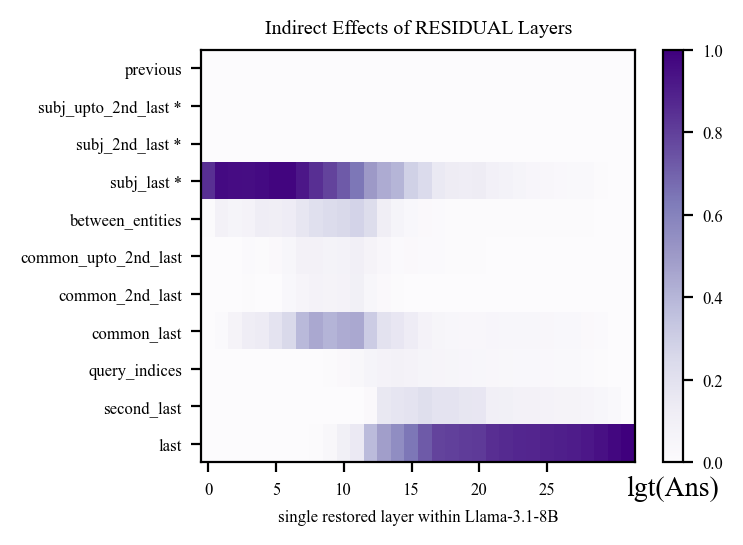

2025-02-19 14:02:05 __main__ INFO     (1/20)  entities=['Germany', 'Japan']
2025-02-19 14:02:05 __main__ INFO     (2/20)  entities=['Hugh Jackman', 'Ryan Reynolds']
2025-02-19 14:02:05 __main__ INFO     (3/20)  entities=['Bhutan', 'Tuvalu']
2025-02-19 14:02:05 __main__ INFO     (4/20)  entities=['Vatican City', 'Mount Athos']
2025-02-19 14:02:05 __main__ INFO     (5/20)  entities=['Rosetta Stone', 'Dead Sea Scrolls']
2025-02-19 14:02:05 __main__ INFO     (6/20)  entities=['Leonardo da Vinci', 'Benjamin Franklin']
2025-02-19 14:02:05 __main__ INFO     (7/20)  entities=['Daredevil', 'Toph Beifong']
2025-02-19 14:02:05 __main__ INFO     (8/20)  entities=['Memento', 'Inception']
2025-02-19 14:02:05 __main__ INFO     (9/20)  entities=['Julius Caesar', 'Nepoleon Bonaparte']
2025-02-19 14:02:05 __main__ INFO     (10/20)  entities=['The Godfather', 'Goodfellas']
2025-02-19 14:02:05 __main__ INFO     (11/20)  entities=['The Green Mile', 'The Shawshank Redemption']
2025-02-19 14:02:05 __main__ I

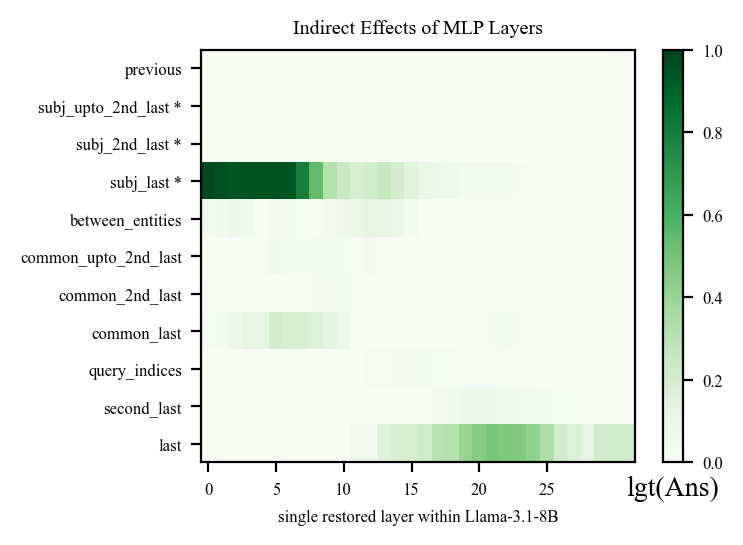

2025-02-19 14:02:05 __main__ INFO     (1/20)  entities=['Germany', 'Japan']
2025-02-19 14:02:05 __main__ INFO     (2/20)  entities=['Hugh Jackman', 'Ryan Reynolds']
2025-02-19 14:02:05 __main__ INFO     (3/20)  entities=['Bhutan', 'Tuvalu']
2025-02-19 14:02:05 __main__ INFO     (4/20)  entities=['Vatican City', 'Mount Athos']
2025-02-19 14:02:05 __main__ INFO     (5/20)  entities=['Rosetta Stone', 'Dead Sea Scrolls']
2025-02-19 14:02:05 __main__ INFO     (6/20)  entities=['Leonardo da Vinci', 'Benjamin Franklin']
2025-02-19 14:02:05 __main__ INFO     (7/20)  entities=['Daredevil', 'Toph Beifong']
2025-02-19 14:02:05 __main__ INFO     (8/20)  entities=['Memento', 'Inception']
2025-02-19 14:02:05 __main__ INFO     (9/20)  entities=['Julius Caesar', 'Nepoleon Bonaparte']
2025-02-19 14:02:05 __main__ INFO     (10/20)  entities=['The Godfather', 'Goodfellas']
2025-02-19 14:02:05 __main__ INFO     (11/20)  entities=['The Green Mile', 'The Shawshank Redemption']
2025-02-19 14:02:05 __main__ I

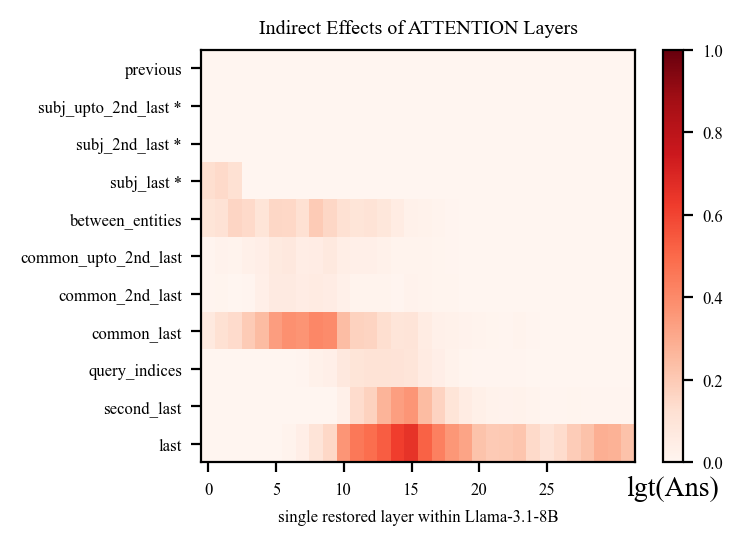

In [137]:
for kind in ["residual", "mlp", "attention"]:
    look_dir = os.path.join(env_utils.DEFAULT_RESULTS_DIR, "causal_tracing_test", kind)

    categorized_effects = []
    for idx, c in enumerate(coincidences["examples"]):
        entities = c["entity_pair"]
        logger.info(f"({idx+1}/{len(coincidences['examples'])})  {entities=}")

        common_entity = entities[1]
        patch_entity = entities[0]
        clean_entity = "placeholder"

        file_name = f"{patch_entity}__<>__{clean_entity}.npz"
        if file_name not in os.listdir(look_dir):
            logger.warning(f"Skipping {file_name}")
            continue

        trace_res = CausalTracingResult.from_npz(os.path.join(look_dir, file_name))
        token_ranges = get_token_ranges(
            mt, trace_res, common_entity=common_entity
        )
        categorized_effects.append(
            get_categorized_indirect_effects(trace_res, token_ranges)
        )

    aie = average_indirect_effects(
        categorized_effects=categorized_effects,
        kind=kind
    )

    plot_trace_heatmap(
        result=aie,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if aie.normalized == True else None
    )

### Introspection Experiment (similar to `Patchscope`)

In [88]:
placeholder_entities = ("one", "two")
placeholder_prompt = prepare_probing_input(
    mt=mt,
    entities=placeholder_entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)

In [89]:
# entities = (entities[1], entities[0])
entities

('Bruce Wayne', 'Tony Stark')

In [90]:
from src.tokens import prepare_input, find_token_range

st = mt.tokenizer.pad_token * (prompt.entity_ranges[0][0]-4) + f"\nQ: {entities[0]}"
inp = prepare_input(
    prompts = st,
    tokenizer=mt,
    return_offsets_mapping=True
)
find_token_range(
    string=st,
    substring=entities[0],
    tokenizer=mt,
    offset_mapping=inp.offset_mapping[0]
)

(206, 208)

In [91]:
prompt.entity_ranges

((206, 208), (209, 211))

In [92]:
for idx, t in list(enumerate(prompt.tokenized["input_ids"][0]))[206:]:
    print(f"{idx} => \"{mt.tokenizer.decode(t)}\"")

206 => " Bruce"
207 => " Wayne"
208 => " and"
209 => " Tony"
210 => " Stark"
211 => "
"
212 => "A"
213 => ":"
214 => " They"
215 => " are"
216 => "/w"
217 => "ere"
218 => " both"


In [93]:
for idx, t in list(enumerate(inp["input_ids"][0]))[206:]:
    print(f"{idx} => \"{mt.tokenizer.decode(t)}\"")

206 => " Bruce"
207 => " Wayne"


In [ ]:
from src.functional import get_hs, extract_rep_at_pos
from src.utils.typing import TokenizerOutput

bare_hs = [
    extract_rep_at_pos(
        mt = mt,
        input = f" {ent}",
        total_length=ent_rng[1],
        locations=[(layer, ent_rng[1] - 1) for layer in [mt.embedder_name] + mt.layer_names]
    )
    for ent, ent_rng in zip(entities, prompt.entity_ranges)
]

In [95]:
icl_hs = [
    get_hs(
        mt = mt,
        input = TokenizerOutput(data = prompt.tokenized),
        locations = [(layer, rng[1] - 1) for layer in [mt.embedder_name] + mt.layer_names],
        return_dict=True
    )
    for ent, rng in zip(entities, prompt.entity_ranges)
]

In [59]:
from src.functional import PatchSpec
from src.functional import generate_with_patch, predict_next_token
from src.utils.typing import TokenizerOutput

print(entities)

clean_pred = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = prompt.tokenized),
)
clean_pred

('Christopher Columbus', 'Vasco da Gama')


[[PredictedToken(token=' explor', prob=0.454833984375, logit=18.71875, token_id=48539),
  PredictedToken(token=' famous', prob=0.208251953125, logit=17.9375, token_id=11495),
  PredictedToken(token=' Portuguese', prob=0.0655517578125, logit=16.78125, token_id=43288),
  PredictedToken(token=' sailors', prob=0.03912353515625, logit=16.265625, token_id=69938),
  PredictedToken(token=' European', prob=0.03619384765625, logit=16.1875, token_id=7665)]]

In [97]:
## bare hs

patches = []
for ent_hs, placeholder_range, ent_range in zip(bare_hs, placeholder_prompt.entity_ranges, prompt.entity_ranges):
    token_pos = placeholder_range[0]
    patches.extend([
        PatchSpec(
            location = (layer, token_pos),
            # patch = ent_hs[(layer, -1)]
            patch = ent_hs[(layer, ent_range[1] - 1)]
        )
        for layer in mt.layer_names
    ])



pred, track_ans = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
    patches=patches,
    token_of_interest=[clean_pred[0][0].token_id]
)

# gen = generate_with_patch(
#     mt = mt, 
#     inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
#     patches = patches,
#     do_sample=False
# )

# print(gen[0])
print(track_ans)
pred

[{90386: (1, PredictedToken(token=' billionaires', prob=0.2470703125, logit=16.40625, token_id=90386))}]


[[PredictedToken(token=' billionaires', prob=0.2470703125, logit=16.40625, token_id=90386),
  PredictedToken(token=' fictional', prob=0.09906005859375, logit=15.4921875, token_id=44682),
  PredictedToken(token=' American', prob=0.059600830078125, logit=14.984375, token_id=3778),
  PredictedToken(token=' actors', prob=0.05096435546875, logit=14.828125, token_id=20142),
  PredictedToken(token=' billionaire', prob=0.044281005859375, logit=14.6875, token_id=47794)]]

In [98]:
# patch only the last token from ICL_hs

patches = []
for ent_hs, placeholder_range, ent_range in zip(icl_hs, placeholder_prompt.entity_ranges, prompt.entity_ranges):
    token_pos = placeholder_range[0]
    patches.extend([
        PatchSpec(
            location = (layer, token_pos),
            # patch = ent_hs[(layer, -1)]
            patch = ent_hs[(layer, ent_range[1] - 1)]
        )
        for layer in mt.layer_names
    ])

pred, track_ans = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
    patches=patches,
    token_of_interest=[clean_pred[0][0].token_id]
)

# gen = generate_with_patch(
#     mt = mt, 
#     inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
#     patches = patches,
#     do_sample=False
# )

# print(gen[0])

print(track_ans)

pred

[{90386: (1, PredictedToken(token=' billionaires', prob=0.282470703125, logit=17.5625, token_id=90386))}]


[[PredictedToken(token=' billionaires', prob=0.282470703125, logit=17.5625, token_id=90386),
  PredictedToken(token=' billionaire', prob=0.1610107421875, logit=17.0, token_id=47794),
  PredictedToken(token=' fictional', prob=0.14892578125, logit=16.921875, token_id=44682),
  PredictedToken(token=' superheroes', prob=0.03704833984375, logit=15.53125, token_id=91818),
  PredictedToken(token=' the', prob=0.033203125, logit=15.421875, token_id=279)]]

In [57]:
from src.functional import predict_next_token

single_probing_prompt = "Who/what is {}? Answer: {} is a"

pred, track_ans = predict_next_token(
    mt = mt,
    inputs = [single_probing_prompt.format(entities[0], entities[0])],
    k=15,
    token_of_interest=[clean_pred[0][0].token_id]
)

print(track_ans)
pred

[{48539: (3345, PredictedToken(token=' explor', prob=1.4126300811767578e-05, logit=4.78515625, token_id=48539))}]


[[PredictedToken(token=' man', prob=0.0650634765625, logit=13.21875, token_id=893),
  PredictedToken(token=' fictional', prob=0.034027099609375, logit=12.5703125, token_id=44682),
  PredictedToken(token=' myth', prob=0.03375244140625, logit=12.5625, token_id=21849),
  PredictedToken(token=' hero', prob=0.0307464599609375, logit=12.46875, token_id=12084),
  PredictedToken(token=' person', prob=0.0290985107421875, logit=12.4140625, token_id=1732),
  PredictedToken(token=' famous', prob=0.028656005859375, logit=12.3984375, token_id=11495),
  PredictedToken(token=' ', prob=0.0207977294921875, logit=12.078125, token_id=220),
  PredictedToken(token=' symbol', prob=0.0206451416015625, logit=12.0703125, token_id=7891),
  PredictedToken(token=' very', prob=0.0190887451171875, logit=11.9921875, token_id=1633),
  PredictedToken(token=' white', prob=0.018218994140625, logit=11.9453125, token_id=4251),
  PredictedToken(token=' historical', prob=0.0179290771484375, logit=11.9296875, token_id=13970),

In [58]:
pred, track_ans = predict_next_token(
    mt = mt,
    inputs = single_probing_prompt.format(entities[1], entities[1]),
    k=15,
    token_of_interest=[clean_pred[0][0].token_id]
)

print(track_ans)
pred

[{48539: (3180, PredictedToken(token=' explor', prob=1.3887882232666016e-05, logit=4.05859375, token_id=48539))}]


[[PredictedToken(token=' Portuguese', prob=0.2646484375, logit=13.9140625, token_id=43288),
  PredictedToken(token=' famous', prob=0.0341796875, logit=11.8671875, token_id=11495),
  PredictedToken(token=' port', prob=0.032623291015625, logit=11.8203125, token_id=2700),
  PredictedToken(token=' ', prob=0.0294647216796875, logit=11.71875, token_id=220),
  PredictedToken(token=' person', prob=0.0244293212890625, logit=11.53125, token_id=1732),
  PredictedToken(token=' character', prob=0.01528167724609375, logit=11.0625, token_id=3752),
  PredictedToken(token=' city', prob=0.0123748779296875, logit=10.8515625, token_id=3363),
  PredictedToken(token=' Brazilian', prob=0.0104217529296875, logit=10.6796875, token_id=36083),
  PredictedToken(token=' town', prob=0.0101776123046875, logit=10.65625, token_id=6424),
  PredictedToken(token=' name', prob=0.00986480712890625, logit=10.625, token_id=836),
  PredictedToken(token=' ship', prob=0.0095672607421875, logit=10.59375, token_id=8448),
  Predic

In [62]:
# layer = mt.layer_name_format.format(16)

# bare_hs_pair = (
#     bare_hs[0][(layer, prompt.entity_ranges[0][1] - 1)],
#     bare_hs[1][(layer, prompt.entity_ranges[1][1] - 1)],
# )

# enriched_hs_pair = (
#     icl_hs[0][(layer, prompt.entity_ranges[0][1] - 1)],
#     icl_hs[1][(layer, prompt.entity_ranges[1][1] - 1)],
# )

In [63]:
# torch.cosine_similarity(
#     bare_hs_pair[0],
#     bare_hs_pair[1],
#     dim=-1
# )

In [64]:
# torch.cosine_similarity(
#     enriched_hs_pair[0],
#     enriched_hs_pair[1],
#     dim=-1
# )

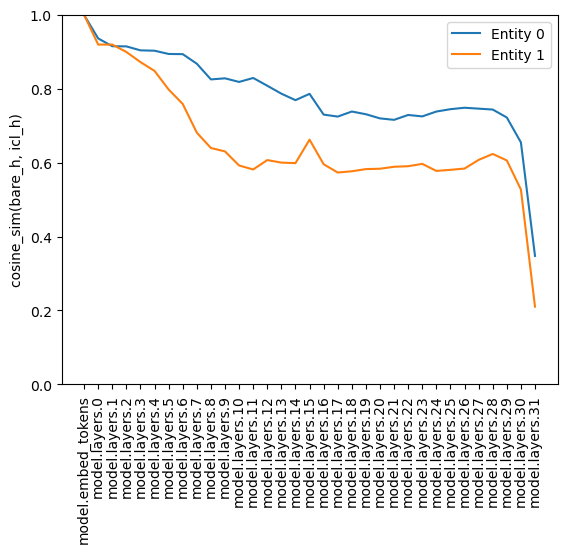

In [65]:
similarity_0 = []
similarity_1 = []

for layer in [mt.embedder_name] + mt.layer_names:
    entity_pos_0 = prompt.entity_ranges[0][1] - 1
    sim_0 = torch.cosine_similarity(
        bare_hs[0][(layer, entity_pos_0)], icl_hs[0][(layer, entity_pos_0)], dim=-1
    )

    similarity_0.append(sim_0.item())

    entity_pos_1 = prompt.entity_ranges[1][1] - 1
    sim_1 = torch.cosine_similarity(
        bare_hs[1][(layer, entity_pos_1)], icl_hs[1][(layer, entity_pos_1)], dim=-1
    )

    similarity_1.append(sim_1.item())

# print(f"{layer}: {sim_0.item()=}, {sim_1.item()=}")

from matplotlib import pyplot as plt
plt.plot(similarity_0, label="Entity 0")
plt.plot(similarity_1, label="Entity 1")

plt.legend()
plt.ylim(0, 1)
plt.ylabel("cosine_sim(bare_h, icl_h)")

plt.xticks(range(mt.n_layer + 1), [mt.embedder_name] + mt.layer_names, rotation=90)
plt.show()
    

### Use the corner as introspection point

2025-02-10 13:24:34 src.operators.estimators INFO     What is the nationality of X? Answer:  |>> self.placeholder_pos=7 | self.inputs['input_ids'].shape=torch.Size([1, 11])
[' British', ' American', ' French', ' German', ' Italian', ' Spanish', ' Russian', ' Chinese', ' Japanese', ' Indian']
2025-02-10 13:24:34 src.operators.estimators INFO     Initialized to [PredictedToken(token='1', prob=0.486572265625, logit=20.109375, token_id=16), PredictedToken(token='2', prob=0.168212890625, logit=19.046875, token_id=17), PredictedToken(token='3', prob=0.1036376953125, logit=18.5625, token_id=18), PredictedToken(token='10', prob=0.0445556640625, logit=17.71875, token_id=605), PredictedToken(token='4', prob=0.02423095703125, logit=17.109375, token_id=19)]


100%|██████████| 200/200 [00:17<00:00, 11.34it/s]


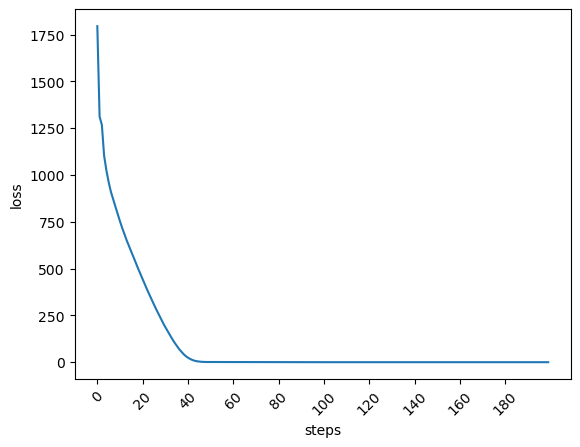

2025-02-10 13:24:52 src.operators.estimators INFO     Tuned to: [PredictedToken(token=' Japanese', prob=0.08056640625, logit=20.0, token_id=11002), PredictedToken(token=' Russian', prob=0.08056640625, logit=20.0, token_id=8690), PredictedToken(token=' Chinese', prob=0.08056640625, logit=20.0, token_id=8620), PredictedToken(token=' German', prob=0.07928466796875, logit=19.984375, token_id=6063), PredictedToken(token=' American', prob=0.07928466796875, logit=19.984375, token_id=3778)]


In [37]:
from src.operators.estimators import CornerEstimator

estimator = CornerEstimator(
    mt = mt, layer_name=mt.layer_names[2], verbose=True,
    prompt = "What is the nationality of X? Answer: ",
    placeholder = "X",
)

# with open(
#     os.path.join(
#         env_utils.DEFAULT_DATA_DIR, 
#         "object_mappings", 
#         "professions.json"
#         # "colors.json"
#     ), "r"
# ) as f:
#     objects = json.load(f)
# # objects = [f" {c}" for c in objects]
# objects = [" Christian", " Muslim", " Hindu", " Buddhist", " Sikh", " Jewish", " Atheist", " Agnostic", " Deist", " Pagan"]
# objects = [" red", " blue", " green", " yellow", " orange", " purple", " pink", " black", " white", " grey"]
objects = [" British", " American", " French", " German", " Italian", " Spanish", " Russian", " Chinese", " Japanese", " Indian"]

token_indices = (
    mt.tokenizer(
        objects,
        add_special_tokens=False,
        return_tensors="pt",
        padding=True,
        padding_side="right",
    )
    .input_ids[:, 0]
    .tolist()
)
print([mt.tokenizer.decode(t) for t in token_indices])

corner = estimator.estimate(
    class_indices=token_indices, 
    n_steps=200, 
    # space="prob",
    target_val=20,
    # concept_subspace_regularizer=0.1
    weight_decay=5e-4
)

In [66]:
placeholder_prompt.entity_ranges

((206, 207), (208, 209))

In [67]:
entities

('Rafael Nadal', 'Javier Bardem')

In [68]:
corner_pos = placeholder_prompt.entity_ranges[1][0]
entity_pos = placeholder_prompt.entity_ranges[0][0]

# corner_pos = placeholder_prompt.entity_ranges[0][0]
# entity_pos = placeholder_prompt.entity_ranges[1][0]

corner_patch = []
for layer in mt.layer_names:
    corner_patch.append(PatchSpec(
        location=(layer, corner_pos),
        patch=corner.corner
    ))
    corner_patch.append(PatchSpec(
        location=(layer, entity_pos),
        patch=icl_hs[0][(layer, prompt.entity_ranges[0][1] - 1)]
        # patch = corner.corner
    ))


pred, track_ans = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
    patches = corner_patch,
    k = 20,
    token_of_interest=[token_indices]
)

pred

[[PredictedToken(token=' tennis', prob=0.51953125, logit=17.546875, token_id=32515),
  PredictedToken(token=' professional', prob=0.2132568359375, logit=16.65625, token_id=6721),
  PredictedToken(token=' athletes', prob=0.0212860107421875, logit=14.3515625, token_id=23579),
  PredictedToken(token=' Spanish', prob=0.0201416015625, logit=14.296875, token_id=15506),
  PredictedToken(token=' world', prob=0.016448974609375, logit=14.09375, token_id=1917),
  PredictedToken(token=' ranked', prob=0.0161895751953125, logit=14.078125, token_id=21682),
  PredictedToken(token=' active', prob=0.0141754150390625, logit=13.9453125, token_id=4642),
  PredictedToken(token=' top', prob=0.011749267578125, logit=13.7578125, token_id=1948),
  PredictedToken(token=' famous', prob=0.0088043212890625, logit=13.46875, token_id=11495),
  PredictedToken(token=' number', prob=0.00873565673828125, logit=13.4609375, token_id=1396),
  PredictedToken(token=' players', prob=0.007648468017578125, logit=13.328125, token

In [71]:
from src.functional import logit_lens

logit_lens(
    mt = mt,
    h = bare_hs[0][(mt.layer_names[25], prompt.entity_ranges[0][1] - 1)],
    interested_tokens=token_indices
)

([PredictedToken(token=' Rafael', prob=0.06689453125, logit=10.5859375, token_id=55500),
  PredictedToken(token=' ATP', prob=0.0643310546875, logit=10.546875, token_id=67656),
  PredictedToken(token=' Roland', prob=0.028564453125, logit=9.734375, token_id=58906),
  PredictedToken(token=' tennis', prob=0.021392822265625, logit=9.4453125, token_id=32515),
  PredictedToken(token=' Wimbledon', prob=0.0208892822265625, logit=9.421875, token_id=91257)],
 {15506: (36,
   PredictedToken(token=' Spanish', prob=0.0016050338745117188, logit=6.85546875, token_id=15506)),
  8753: (167,
   PredictedToken(token=' French', prob=0.00035953521728515625, logit=5.359375, token_id=8753)),
  7904: (1637,
   PredictedToken(token=' Indian', prob=5.632638931274414e-05, logit=3.505859375, token_id=7904)),
  6063: (3358,
   PredictedToken(token=' German', prob=3.0875205993652344e-05, logit=2.904296875, token_id=6063)),
  15155: (4648,
   PredictedToken(token=' Italian', prob=2.3066997528076172e-05, logit=2.61328